# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
import sklearn
from collections import deque
from numpy.linalg import norm 

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

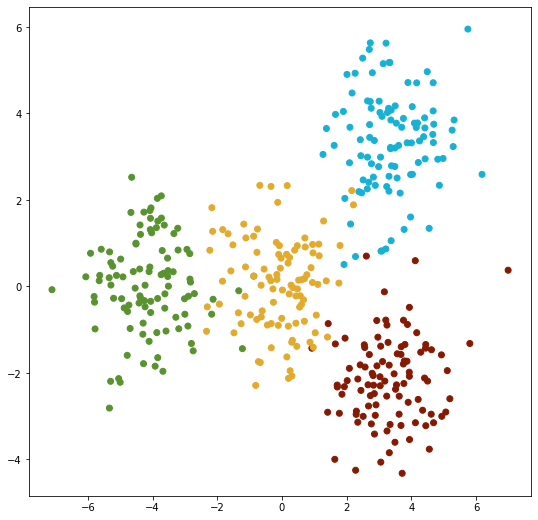

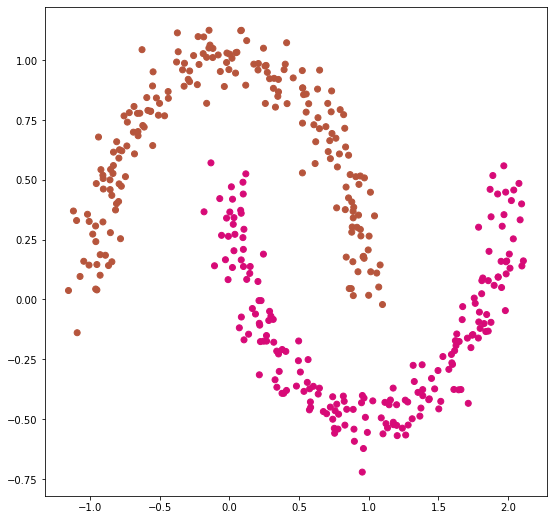

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
def random_center(X, k):    
    min_element = np.min(X[:,0])
    max_element =  np.max(X[:,0])
    centroids = np.random.uniform(min_element, max_element, size=(k,1))
    for i in range(1, X.shape[1]):
        min_element = np.min(X[:,i])
        max_element =  np.max(X[:,i])
        centroids = np.hstack((centroids, np.random.uniform(min_element, max_element, size=(k,1))))
        
    return centroids

def sample_center(X, k):
    return X[np.random.randint(0, X.shape[0], size=k)]

def k_means_plus(X,k):
    centroids = [X[np.random.randint(0, X.shape[0])]]
    for _ in range(k - 1):
        distance = [(norm(X - c, axis=1))**2 for c in centroids]
        dist_min=np.min(distance,  axis=0)
        sum_dist = np.cumsum(dist_min)
        Rnd=np.random.uniform(0, 1)
        arg = sum_dist/sum_dist[-1] > Rnd
        centroids.append(X[np.argmax(arg)])
    return centroids

In [5]:
class KMeans:
    def __init__(self, n_clusters, init="k-means++", max_iter=300):
        self.k = n_clusters
        self.max_iter = max_iter
        self.init = init 
        
    def fit(self, X, y=None):
        if self.init == "random":
            centroids = random_center(X, self.k)
        elif self.init == "sample":
            centroids = sample_center(X, self.k)
        elif self.init == "k-means++":
            centroids = k_means_plus(X,self.k)
        else:
            print("oops")
            return        
            
        
        distance = [norm(X - c, axis=1) for c in centroids]
        y0 = np.argmin(distance,  axis=0)
        eps = float('inf')     
        iters = 0
        
        while (eps > 0) and (iters < self.max_iter):
            for i in range(self.k):
                arg_points = y0 == i
                weight = np.sum(y0 == i)
                if weight:
                    centroids[i] = np.sum(X[arg_points], axis=0) / weight 
            
            distance = [norm(X - c, axis=1) for c in centroids]
            y1 = np.argmin(distance,  axis=0)
            
            eps = np.sum(y0-y1)
            y0 = y1
            iters += 1
        
        self.centroids = np.array(centroids)

    
    def predict(self, X):
        distance = [norm(X - c, axis=1) for c in self.centroids]
        return np.argmin(distance, axis=0)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

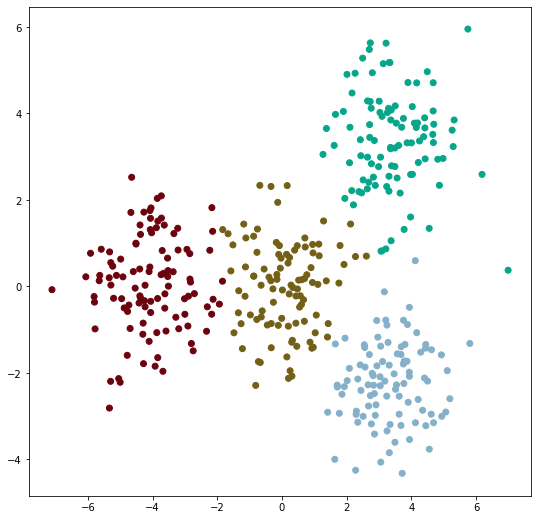

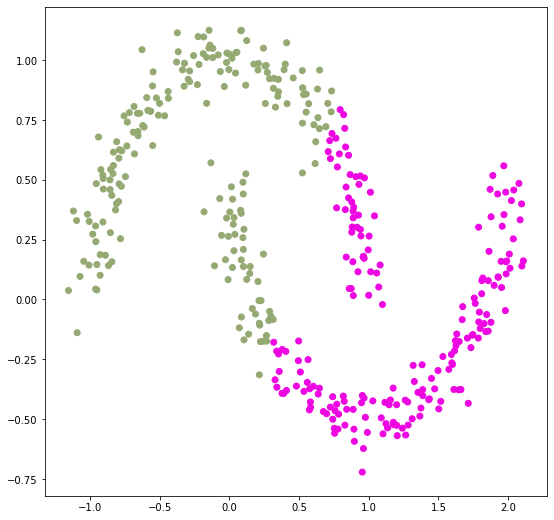

In [6]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [23]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        
        n = X.shape[0]
        tree = sklearn.neighbors.KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        
        count = tree.query_radius(X, self.eps, count_only=True, return_distance=False)
        neighbors, distance = tree.query_radius(X, self.eps, return_distance=True)
        
        # каждая точка кластер
        claster = np.arange(n)
        core = claster[count >= self.min_samples]
        core_neighbors = neighbors[core]
        
        #объединение кластеров
        for c, c_n in zip(core, core_neighbors):
            claster[c_n] = claster[c]
        
        l = np.unique(claster)
        t = dict(zip(l, np.arange(l.size)))
        labels = [t[c] for c in claster]
        
        return labels


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

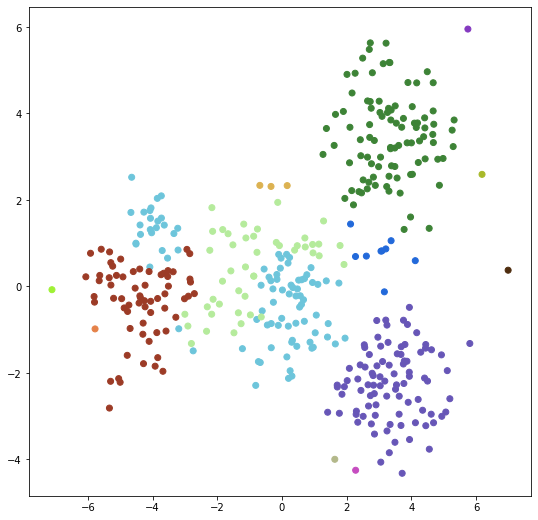

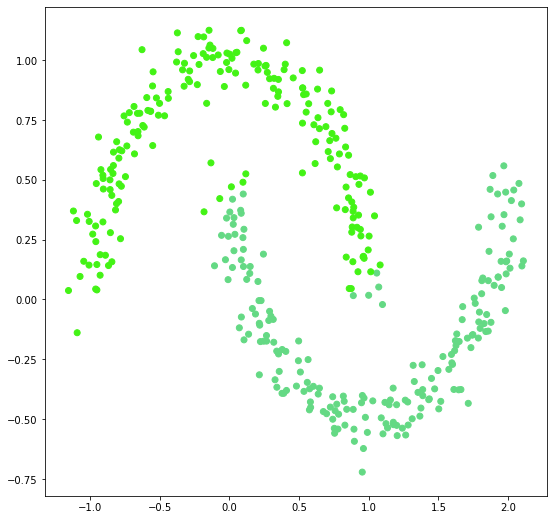

In [33]:
dbscan = DBScan(eps=1, min_samples=5)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.5, min_samples=20)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [16]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
        
    def dist(self, claster1, claster2):
        if self.linkage == 'average':
            result = 0
            for point in claster1:
                result += np.sum(norm(claster2 - point, axis=0))
            result = result / (claster1.shape[0] * claster2.shape[0])
            return result         
        
        if self.linkage == 'single':
            result = float('inf')
            for point in claster1:
                result = min(*norm(claster2 - point, axis=1), result)
            return result
        
        if self.linkage == 'complete':
            max_dist = 0
            for point in claster1:
                max_dist = max(max_dist, *norm(claster2 - point, axis=1))
            return max_dist  
        
    def fit_predict(self, X, y=None):
        clusters = [[i] for i in range(X.shape[0])]
        
        num = len(clusters)
        temp = 0
        while num > self.n_clusters:
            matrix = np.zeros((num, num))
            np.fill_diagonal(matrix, float('inf'))
            for i in range(num - 1):
                for j in range(i + 1, num):
                    temp = self.dist(X[clusters[i],], X[clusters[j],])
                    matrix[i,j] = temp
                    matrix[j,i] = temp 
            neighbors = np.argmin(matrix, axis=1)

            for i in range(num):
                if  clusters[i] and clusters[neighbors[i]]:                  
                
                    clusters[i].extend(clusters[neighbors[i]])
                    clusters[neighbors[i]] = None           
                
                    num -= 1
                    if num == self.n_clusters:
                        break
                
            clusters = list(filter(None, clusters))                
        
        labels = np.zeros(X.shape[0], dtype=int)
        
        for i in range(num):
            labels[clusters[i]] = i
        
        print(np.unique(labels))
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

[0 1 2 3 4]


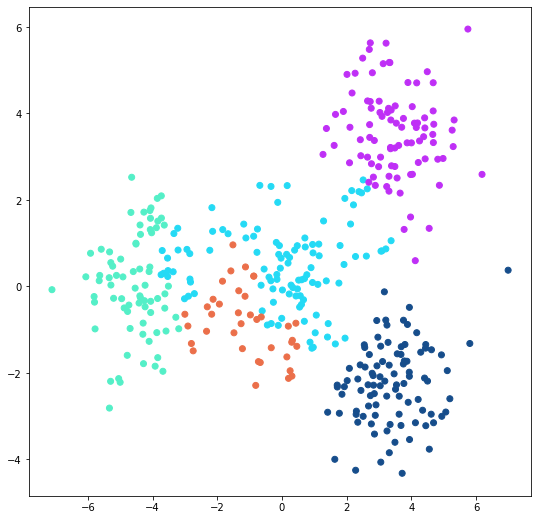

[0 1]


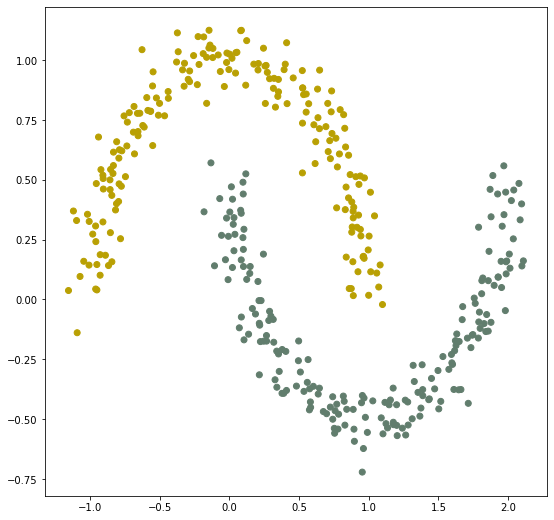

In [19]:
agg_clustering = AgglomertiveClustering(n_clusters=5, linkage="complete")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [11]:
def read_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image, path):
    cv2.imwrite(path, image)

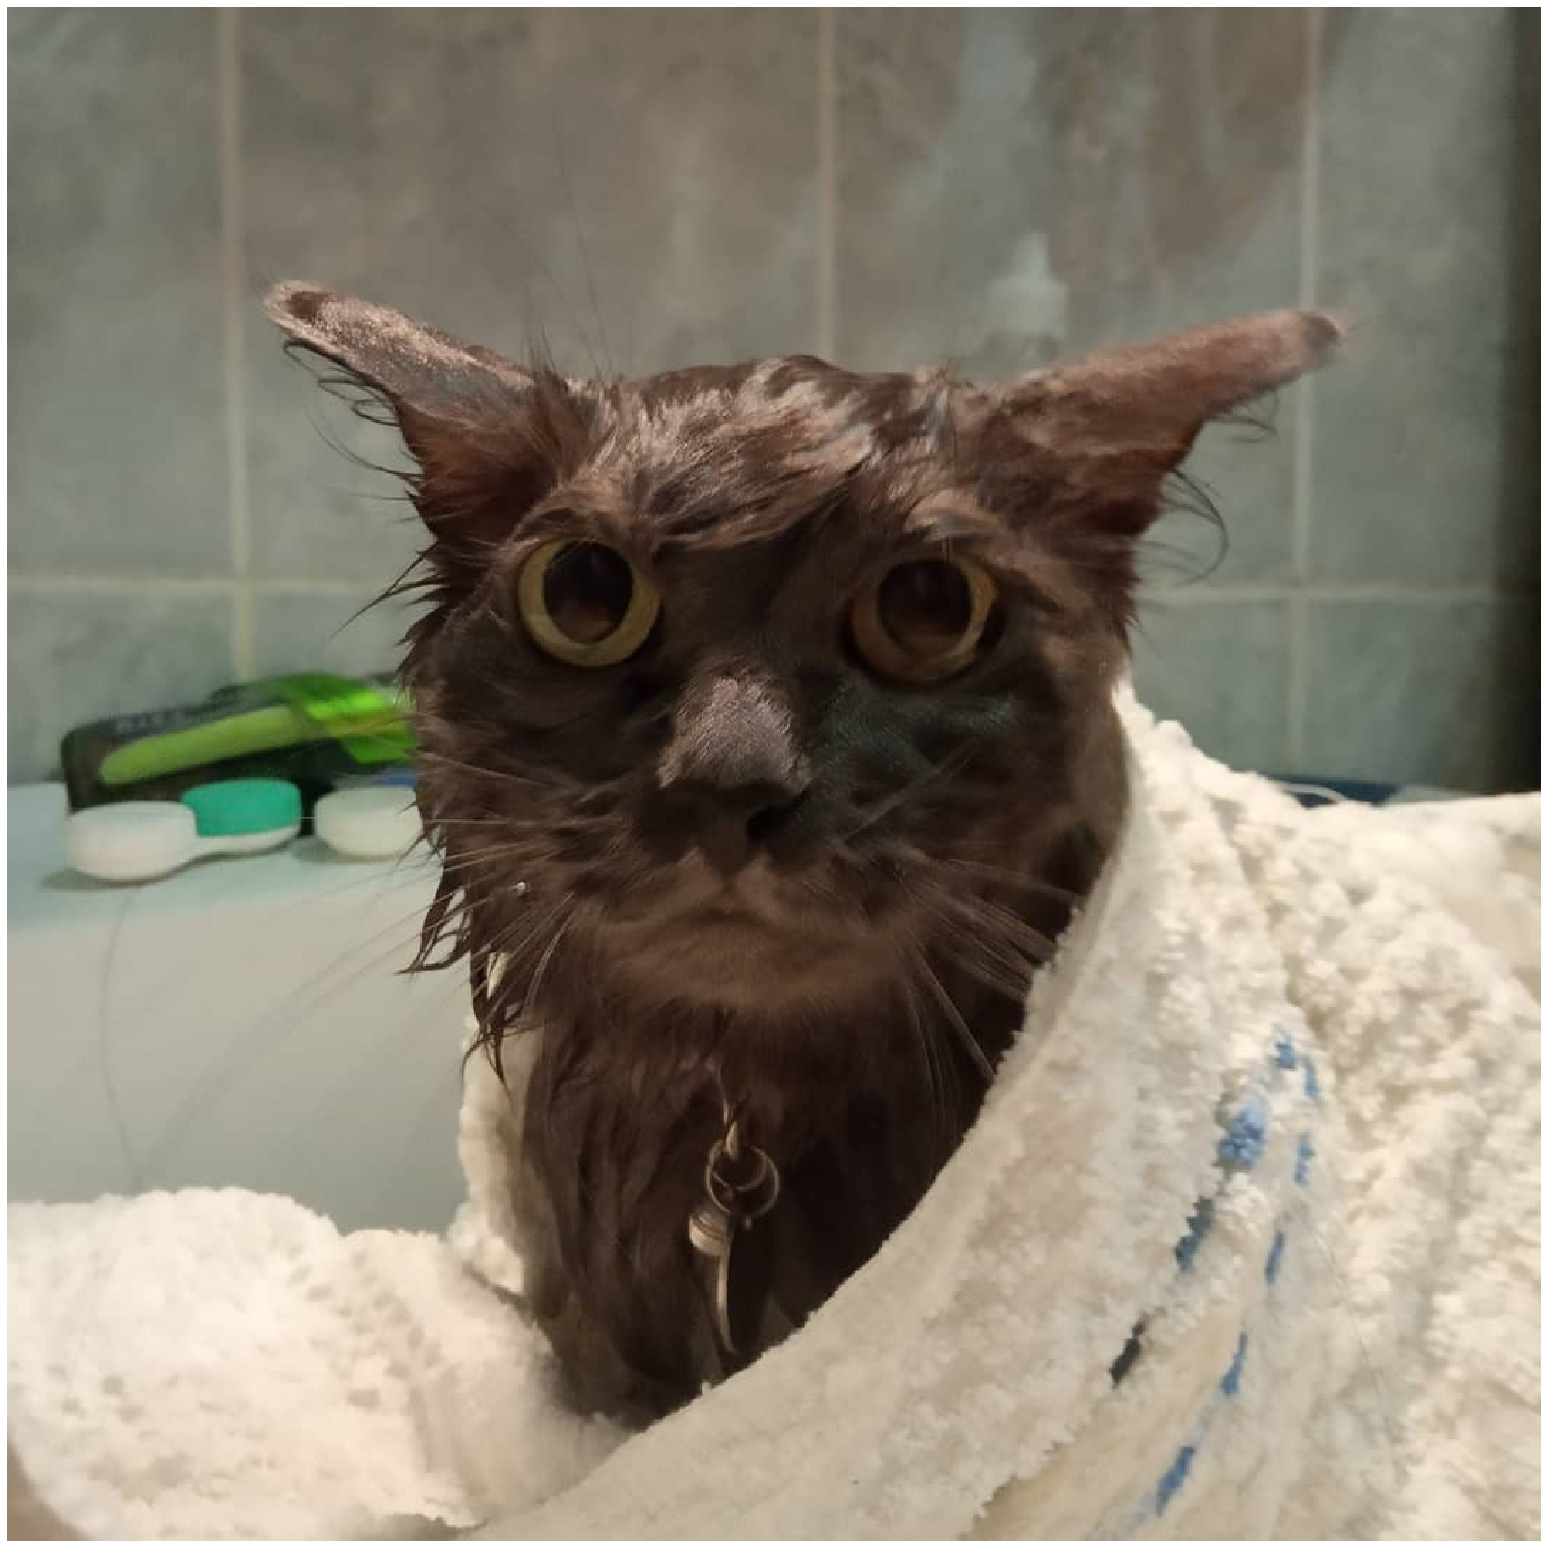

In [12]:
show_image(read_image("./image.jpg"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [13]:
def clusterize_image(image, n_clusters=8, **kwargs):
    k_means = KMeans(n_clusters=n_clusters, init="k-means++", max_iter=100)
    k_means.fit(image.reshape(-1, 3))
    
    cluster_colors = k_means.centroids.astype(int)
    clusters = k_means.predict(image.reshape(-1, 3))
    recolored = cluster_colors[clusters].reshape(image.shape)
    return recolored

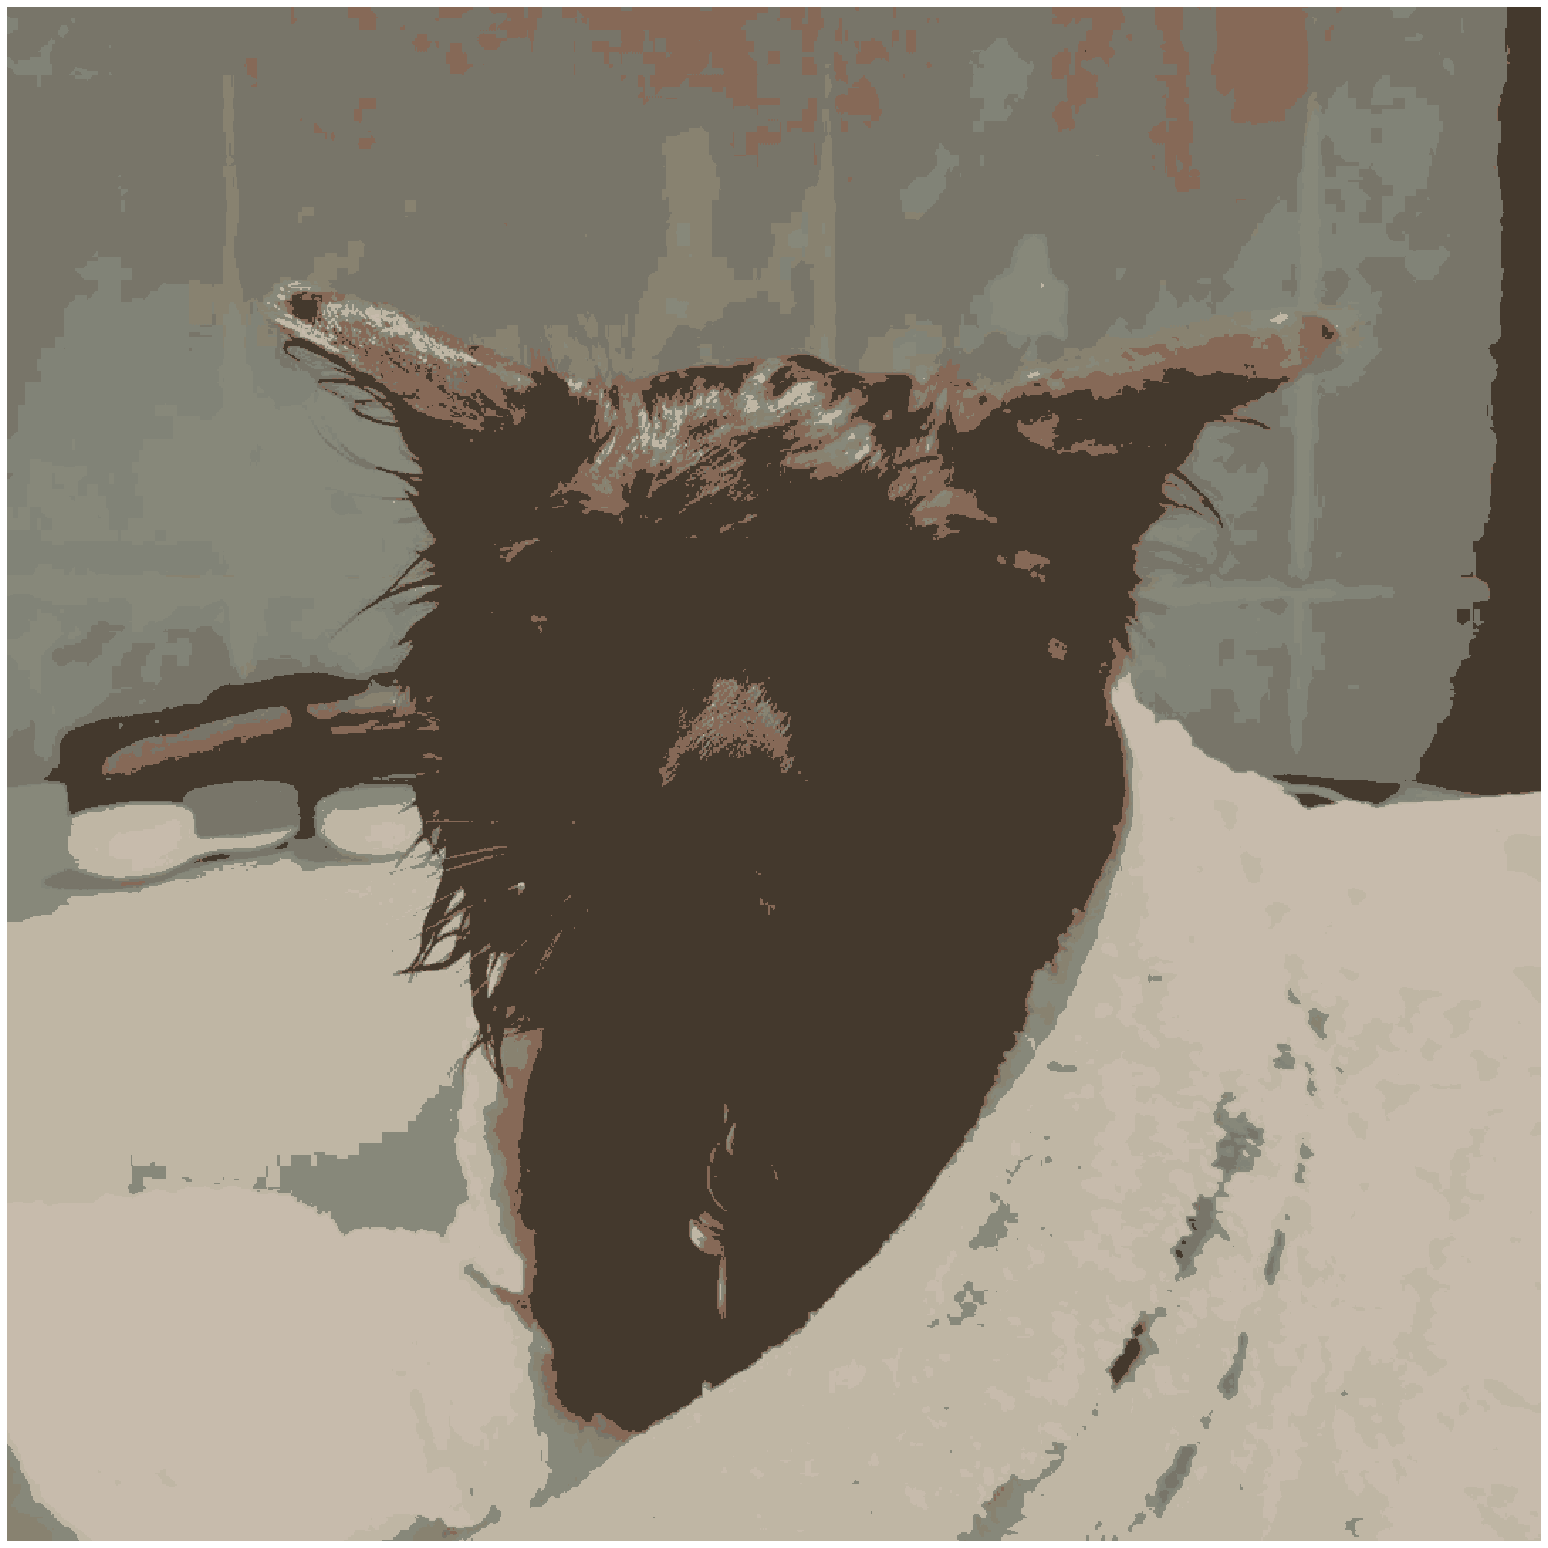

In [14]:
image = read_image("./image.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")